# Classification of Time Series Using sktime

Miles Porter  
Trimble Central AI  
miles_porter@trimble.com  
January 18, 2022

## Introduction

"The subject of clustering and classification of time series with applications in fields such as geology, medicine, environmental science, astronomy, finance and economics, has attracted substantial attention over the last two to three decades."

-- Maharaj, Elizabeth Ann, et al. Time Series Clustering and Classification. 2019.

A number of deep learning techniques exist for dealing with time series data.  However, as is common with deep neural networks, these models tend to take a long time to train, and the resulting models tend to be very large.  The sktime python package offers a number of algorithms for classifying time series data.  The purpose of this document is to highlight some of these models and provide some basic comparisons in terms of performance and accuracy.

The [sktime](https://www.sktime.org/en/stable/) package offers over twenty different ML models for time series classification.  This notebook focuses just on the following, as they are representative of the major types of algorithms sktime has to offer:

- Dictionary Based Models
    - IndividualBOSS
- Distance Based Models
    - KNeighborsTimeSSeriesClassifier
- Interval Based
    - TimeSeriesForestClassifier
- Shapelet-based
    - ShapletTranformClassifier
- Feature-based
    - MatrixProfileClassifier

## Training Dataset: OpenAI Lunar Lander

A common dataset was created in order to evaluate these time series classification algorithms.  The dataset consists of 2000 time series which are divided into two balanced classes.  The data comes from the OpenAI gym "Lunar Lander" game, and represents the magnitude of the velocity of the Lander as the game is played.  

The following video demonstrates the OpenAI Gym Lunar Lander game.

![Watch the video](original.gif)

(https://gym.openai.com/envs/LunarLander-v2/)

Two neural networks were trained with reinvorcement learning (DQN).  The first neural network was trained to a relatively high reward threshold.  This neural net was used to create an "expert" agent for playing the game.  Similarly, a second neural net was trained to a much lower threshold, and was used to create a "novice" agent.  1000 "missions" were flown for each agent, and the first 85 steps in the simulation were saved.  The simulation steps consists of 6 parameters that describe the environment.  Of those six parameters, the X velocity and Y velocity value of the lander were used.  The goal of this notebook is to evaluate the classification of univariant time series.  As a result, the X and Y velocity values where combined into a single value that represents the magnitude of the overall velocity using the following formula:

$ M_v = f(X_v,Y_v) = \sqrt{X_v^2+y_v^2} $ 

The following code loads up the data that was saved as part of the 2000 simulated missions.

In [1]:
#!pip install pandas

import pandas as pd
import numpy as np
from glob import glob
from math import sqrt

novice_mission_files = glob("./data/computer_missions_100/*.csv")
expert_mission_files = glob("./data/computer_missions_500/*.csv")

def get_file(filename, label):
    df_new = pd.read_csv(filename, header=None)
    df_new.columns = ['X','Y','XV', 'YV', 'Angle', 'Angular_Velocity', 'Leg_0_Ground', 'Leg_1_Ground']

    df_new['VM'] = df_new.apply(lambda row: sqrt(row['XV']**2+row['YV']**2), axis=1)

    
    df_new['XA'] = np.gradient(df_new['XV'])
    df_new['YA'] = np.gradient(df_new['YV'])
    df_new['AM'] = df_new.apply(lambda row: sqrt(row['XA']**2+row['YA']**2), axis=1)
        
    df_new['XJ'] = np.gradient(df_new['XA'])
    df_new['YJ'] = np.gradient(df_new['YA'])
    df_new['JM'] = df_new.apply(lambda row: sqrt(row['XJ']**2+row['YJ']**2), axis=1)
    
    
    df_new['Label']=label
    df_new['File']=filename.split("/")[-1]
    df_new['Idx']=[x for x in range(len(df_new))]
    df_new = df_new[['Idx','X','Y','XV', 'YV','VM', 'XA', 'YA', 'AM', 'XJ', 'YJ', 'JM', 'Angle', 'Angular_Velocity', 'Leg_0_Ground', 'Leg_1_Ground', 'File', 'Label']]
    return df_new

# Create random balanced training set.  N random novice and N expert files

expert_data_list = [{"File":f, "df":get_file(f, 'expert')} for f in expert_mission_files]
novice_data_list = [{"File":f, "df":get_file(f, 'novice')} for f in novice_mission_files]

print("We have {} expert files.".format(len(expert_data_list)))
print("We have {} novice files.".format(len(novice_data_list)))

We have 1000 expert files.
We have 1000 novice files.


## Basic Exploratory Data Analysis

The following code displays the data.  The first set of graphs consists of the 5 random expert and 5 random novice missions.  Again, the time series data in the graphs consists of the combined magnitude of the velocity of the simulated lunar lander missions as flown by the expert and novice AI agents.

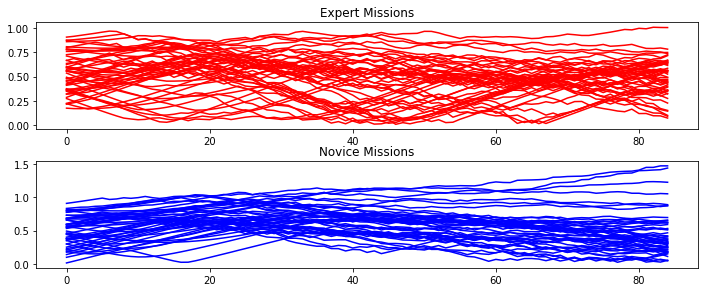

In [2]:
from matplotlib import pyplot as plt
import random

random.shuffle(expert_data_list)
random.shuffle(novice_data_list)

expert_plots = [x['df']['VM'][:85] for x in expert_data_list][:50]
novice_plots = [x['df']['VM'][:85] for x in novice_data_list][:50]

fig, ax = plt.subplots(2,1, figsize=(10,4))
fig.tight_layout() 

for x in expert_plots:
    ax[0].plot(x, color='red')
    
for x in novice_plots:
    ax[1].plot(x, color='blue')
    
ax[0].set_title("Expert Missions")
ax[1].set_title("Novice Missions")
plt.show()
    


A second way to visualize the two data sets is to look at some descriptive statistics on the time series data.  Perhaps the simpliest way to do that is to consider the mean and standard deviation of the time series values.  Of course, the values in the time series are autocorrelated.  However, in just looking at the mean and standard deviation of the data we can see that the series are quite similar.  Clearly, based on mean and standard deviation, the data is not cleanly or even approximatly separable.  As a result, trying to use a model that simply clusters the series based on these to descriptive statistics probably will not be very successful.

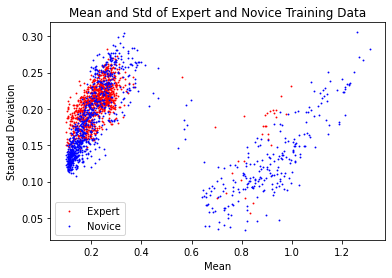

In [3]:
exp_mean = [np.mean(x['df']['VM']) for x in expert_data_list]
exp_std = [np.std(x['df']['VM']) for x in expert_data_list]
nov_mean = [np.mean(x['df']['VM']) for x in novice_data_list]
nov_std = [np.std(x['df']['VM']) for x in novice_data_list]

plt.scatter(exp_mean, exp_std, c='red', s=.75, label="Expert")
plt.scatter(nov_mean, nov_std, c='blue', s=.75, label="Novice")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.legend()
plt.title("Mean and Std of Expert and Novice Training Data")
plt.show()

As can be seen in the sample data above, the challenge of separating out the novice and expert missions is not necessarily trivial.

## Setting Up Data for Training and Testing

The following code will split up the data into train and test sets.

In [4]:
import random

def split_list(l, p):
        random.shuffle(l)
        cut = int(len(l)*p)
        list_1 = l[:cut]
        list_2 = l[cut:]
        return(list_1, list_2)
    
novice_train, novice_test = split_list(novice_data_list, .8)
expert_train, expert_test = split_list(expert_data_list, .8)

print("We now have...")
print("Expert train: {} missions".format(len(expert_train)))
print("Expert test: {} missions".format(len(expert_test)))
print("Novice train: {} missions".format(len(novice_train)))
print("Novest test: {} missions".format(len(novice_test)))


We now have...
Expert train: 800 missions
Expert test: 200 missions
Novice train: 800 missions
Novest test: 200 missions


The following cell provides a method to add an index to the time series data.  The sktime data relies on the timeseries data being 2 dimensional.  Since the time dimension is one of the dimensions, this is simply a 2-dimensional representation of a univariate time series.  It should be mentioned that sktime is also able to handle 3-dimensional input.  For information on that higher dimensional data format, please refer to the sktime documentation.

In [5]:
def add_idx(data):
    df = pd.DataFrame()
    df['d'] = data
    
    df['idx'] = range(len(data))
    df = df[['idx','d']]
    return list(df.values.tolist())

x = [5,6,7]
x_idx = add_idx(x)
assert x_idx==[[0, 5], [1, 6], [2, 7]]

print("Test passed.")
    

Test passed.


## Structuring the Data for sktime

Some of the models in the sktime package have a requirement that the time series data all be the same length for training and inference.  In order to accomidate that, and to make the problem a little harder, we limit the data to the first 85 steps in the simulation.  (This can also be seen in the graphs above.)  In order to match the coding samples for the sktime library, the code below organizes the input data into a pandas dataframe consisting of a single column "dim_0".  Each value in this column contains the time series as a pandas "series" object.  

In [6]:
from sklearn.metrics import accuracy_score

train_series_list = [pd.core.series.Series(x['df']['VM'][:85]) for x in expert_train] + [pd.core.series.Series(x['df']['VM'][:85]) for x in novice_train]

X_train = pd.DataFrame()
X_train['dim_0']=train_series_list
y_train = np.array(['expert' for _ in expert_train] + ['novice' for _ in novice_train])

test_series_list = [pd.core.series.Series(x['df']['VM'][:85]) for x in expert_test] + [pd.core.series.Series(x['df']['VM'][:85]) for x in novice_test]
X_test = pd.DataFrame()
X_test['dim_0']=test_series_list

y_test = np.array(np.array(['expert' for _ in expert_test] + ['novice' for _ in novice_test]))

print("The first training patern has length: {} ".format(len(X_train.iloc[1][0])))


The first training patern has length: 85 


## Training the Models

The following code runs through the different 5 sample time series classification models and calculates the training time, inference time and final accuracy of the models.

In [7]:
#!pip install esig
#!pip install tsfresh
from sktime.classification.all import ColumnEnsembleClassifier, RandomIntervalSpectralEnsemble, RandomIntervalSpectralEnsemble, IndividualBOSS, KNeighborsTimeSeriesClassifier, ShapeletTransformClassifier, MrSEQLClassifier
import sktime.classification.all
from sktime.classification.feature_based import MatrixProfileClassifier
from datetime import datetime

classifiers = ['IndividualBOSS', 
               'KNeighborsTimeSeriesClassifier', 
               'TimeSeriesForestClassifier', 
               'MrSEQLClassifier',
               'MatrixProfileClassifier']

def factory(classname):
    try:
        cls = getattr(sktime.classification.all, classname)
    except:  #Unfortunate kluge for matrix profiles.
        cls = getattr(sktime.classification.feature_based, classname)
    return cls()

for c in classifiers:
    _ = factory(c)


print("Classifiers appear to be present.")

results = []
for classifier_name in classifiers:
    start = datetime.now()
    print("Working on: {}".format(classifier_name))
    start = datetime.now()
    classifier = factory(classifier_name)
    
    # Train the model
    classifier.fit(X_train, y_train)
    
    trained_t = datetime.now()-start
    
    start = datetime.now()
    
    # Predict results on test data
    y_pred = classifier.predict(X_test)
    
    inference_t = datetime.now()-start
    
    # Measure accuracy of predictions against "ground" truth.
    a = accuracy_score(y_test, y_pred)
    
    # Save resultes
    results.append([classifier_name, trained_t.seconds/len(X_train), inference_t.seconds/len(X_test), a])

df = pd.DataFrame(data=results)
df.columns = ['Classifier', 'Training_Time', 'Inference_Time', 'Accuracy']

print("Models trained.  Results in tabular form:\n")
print(df)    


/tmp/ipykernel_339862/123766059.py:19: FutureWarning: Call to deprecated class MrSEQLClassifier. (MrSEQLClassifier will be removed in v0.10.0. It will be replaced with an implementation based on Numba.) -- Deprecated since version 0.8.1.
  return cls()
/tmp/ipykernel_339862/123766059.py:19: FutureWarning: Call to deprecated class SEQLCLF. (SEQLCLF will be removed in v0.10.0) -- Deprecated since version 0.8.1.
  return cls()


Classifiers appear to be present.
Working on: IndividualBOSS
Working on: KNeighborsTimeSeriesClassifier


/home/mporter/projects/inverted_pendulum-master/venv/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1474: UserWarning: Cython DTW is deprecated from V0.10
  out[i, j] = metric(X[i], Y[j], **kwds)


Working on: TimeSeriesForestClassifier
Working on: MrSEQLClassifier


/tmp/ipykernel_339862/123766059.py:19: FutureWarning: Call to deprecated class MrSEQLClassifier. (MrSEQLClassifier will be removed in v0.10.0. It will be replaced with an implementation based on Numba.) -- Deprecated since version 0.8.1.
  return cls()
/tmp/ipykernel_339862/123766059.py:19: FutureWarning: Call to deprecated class SEQLCLF. (SEQLCLF will be removed in v0.10.0) -- Deprecated since version 0.8.1.
  return cls()


Working on: MatrixProfileClassifier
Models trained.  Results in tabular form:

                       Classifier  Training_Time  Inference_Time  Accuracy
0                  IndividualBOSS       0.000000          0.0075    0.7750
1  KNeighborsTimeSeriesClassifier       0.000000          0.0550    0.9025
2      TimeSeriesForestClassifier       0.003750          0.0000    0.9625
3                MrSEQLClassifier       0.039375          0.0000    0.8400
4         MatrixProfileClassifier       0.006250          0.0050    0.7525


## Viewing the Results Graphically

The following code displays a graph of the performance for training and inference vs the accuracy of the different models.

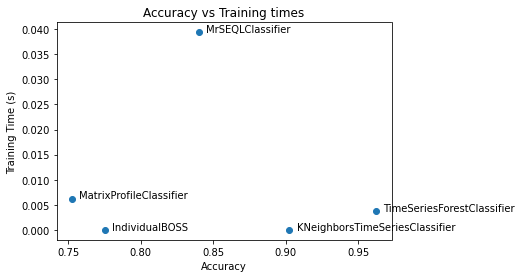

Text(0.5, 1.0, 'Accuracy vs Inference times')

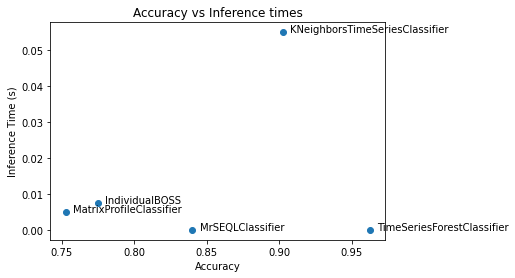

In [8]:
plt.scatter(df['Accuracy'],df['Training_Time'])

x = df['Accuracy'].values
y = df['Training_Time'].values
s = df['Classifier'].values


for i in range(len(x)):
    plt.text(x[i]+.005, y[i], s[i])
plt.xlabel("Accuracy")
plt.ylabel("Training Time (s)")
plt.title("Accuracy vs Training times")

plt.show()

plt.scatter(df['Accuracy'],df['Inference_Time'])

x = df['Accuracy'].values
y = df['Inference_Time'].values
s = df['Classifier'].values


for i in range(len(x)):
    plt.text(x[i]+.005, y[i], s[i])
plt.xlabel("Accuracy")
plt.ylabel("Inference Time (s)")
plt.title("Accuracy vs Inference times")

## Conclusion

The above data shows that, for this problem, while all of the models perform better than just "guessing", the TimeSeriesForestClassifier was very accurate (over 95%) in correctly identifying the type of agent responsible for the time series in our test set.  The TimeSeriesForestClassifier was also highly efficient in terms of training and inference times.

It should be noted that the different models used in this example were not tuned, rather they were implemented with just their default settings.  Results of the above would likely be different if the models were tuned.  It is also worth noting that that there are over 15 additional time series classification models available in the sktime dataset.  

This concludes this overview of the sktime time series models available for time series classification.

Miles Porter  
January 18, 2022  
miles_porter@trimble.com  
